# Predictive analysis of continuous numbers with KNR

[Global Temperature Time Series](https://datahub.io/core/global-temp#data). Data are included from the GISS Surface Temperature (GISTEMP) analysis and the global component of Climate at a Glance (GCAG). Two datasets are provided: 1) global monthly mean and 2) annual mean temperature anomalies in degrees Celsius from 1880 to the present.

## Description 

1. GISTEMP Global Land-Ocean Temperature Index:

Combined Land-Surface Air and Sea-Surface Water Temperature Anomalies [i.e. deviations from the corresponding 1951-1980 means]. Global-mean monthly […] and annual means, 1880-present, updated through most recent month.

2. Global component of Climate at a Glance (GCAG):

Global temperature anomaly data come from the Global Historical Climatology Network-Monthly (GHCN-M) data set and International Comprehensive Ocean-Atmosphere Data Set (ICOADS), which have data from 1880 to the present. These two datasets are blended into a single product to produce the combined global land and ocean temperature anomalies. The available timeseries of global-scale temperature anomalies are calculated with respect to the 20th century average […].

## Theoretical background 

- [Nearest Neighbors Regression](http://scikit-learn.org/stable/modules/neighbors.html#regression)
- [sklearn.neighbors.KNeighborsRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)
- [Digits Classification Exercise](http://scikit-learn.org/stable/auto_examples/exercises/plot_digits_classification_exercise.html)
--- 

---

In [1]:
import numpy as np
import pandas as pd
import scipy, scipy.stats
import matplotlib.pyplot as plt
from fitter import Fitter
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

import seaborn as sns
sns.set()

In [2]:
data = pd.read_json("data/temperature/monthly_json.json") 

In [3]:
data.head()

,Date,Mean,Source
0,2016-12-06,0.7895,GCAG
1,2016-12-06,0.8100,GISTEMP
2,2016-11-06,0.7504,GCAG
3,2016-11-06,0.9300,GISTEMP
4,2016-10-06,0.7292,GCAG


In [4]:
data = data.pivot(index='Date', columns='Source', values='Mean')

In [5]:
data.head()

Source,GCAG,GISTEMP
Date,,
1880-01-06,0.0009,-0.30
1880-02-06,-0.1229,-0.21
1880-03-06,-0.1357,-0.18
1880-04-06,-0.0499,-0.27
1880-05-06,-0.0738,-0.14


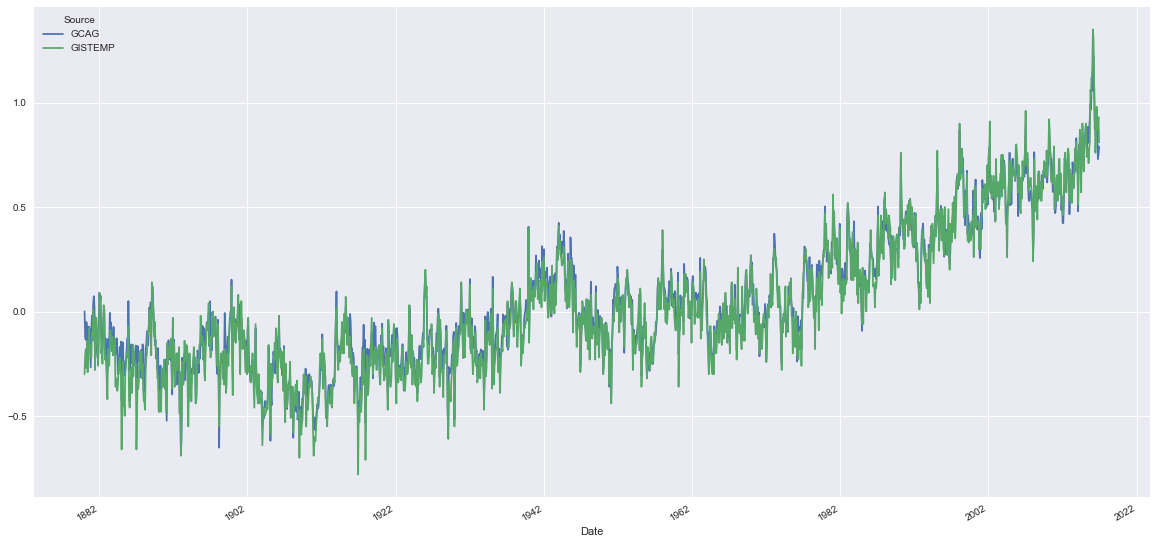

In [6]:
data.plot(figsize=(20,10))

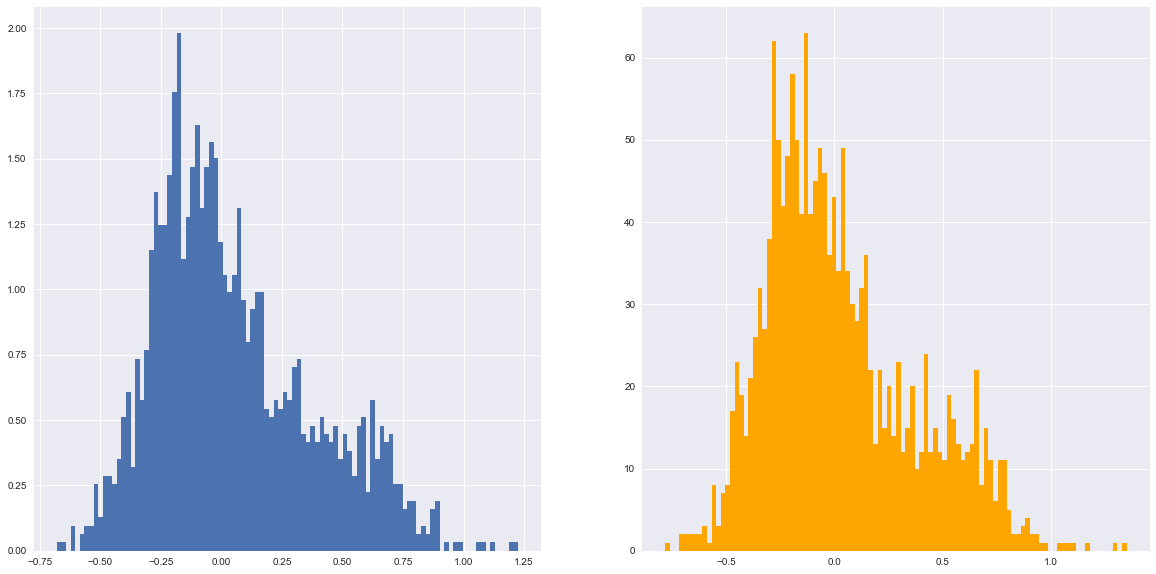

In [7]:
plt.figure(1, figsize=(20,10))

plt.subplot(1,2,1)
plt.hist(data['GCAG'], bins=100, density=True)

plt.subplot(1,2,2)
plt.hist(data['GISTEMP'], bins=100, color='orange')

plt.show()

In [8]:
data.describe()

Source,GCAG,GISTEMP
count,1644.000000,1644.000000
mean,0.048797,0.024380
std,0.326230,0.343709
min,-0.679600,-0.780000
25%,-0.190625,-0.230000
50%,-0.021650,-0.050000
75%,0.252150,0.230000
max,1.224500,1.350000


In [9]:
loc_gcag = 0.048797
scale_gcag = 0.326230
lower = scipy.stats.norm.ppf(0.01,loc_gcag,scale_gcag)
upper = scipy.stats.norm.ppf(0.99,loc_gcag,scale_gcag)
x_gcag = scipy.linspace(lower,upper,100)

y_gcag = scipy.stats.norm.pdf(x_gcag,loc_gcag,scale_gcag)

In [10]:
loc_gistemp = 0.024380
scale_gistemp = 0.343709
lower = scipy.stats.norm.ppf(0.01,loc_gistemp,scale_gistemp)
upper = scipy.stats.norm.ppf(0.99,loc_gistemp,scale_gistemp)
x_gistemp = scipy.linspace(lower,upper,100)

y_gistemp = scipy.stats.norm.pdf(x_gistemp,loc_gistemp,scale_gistemp)

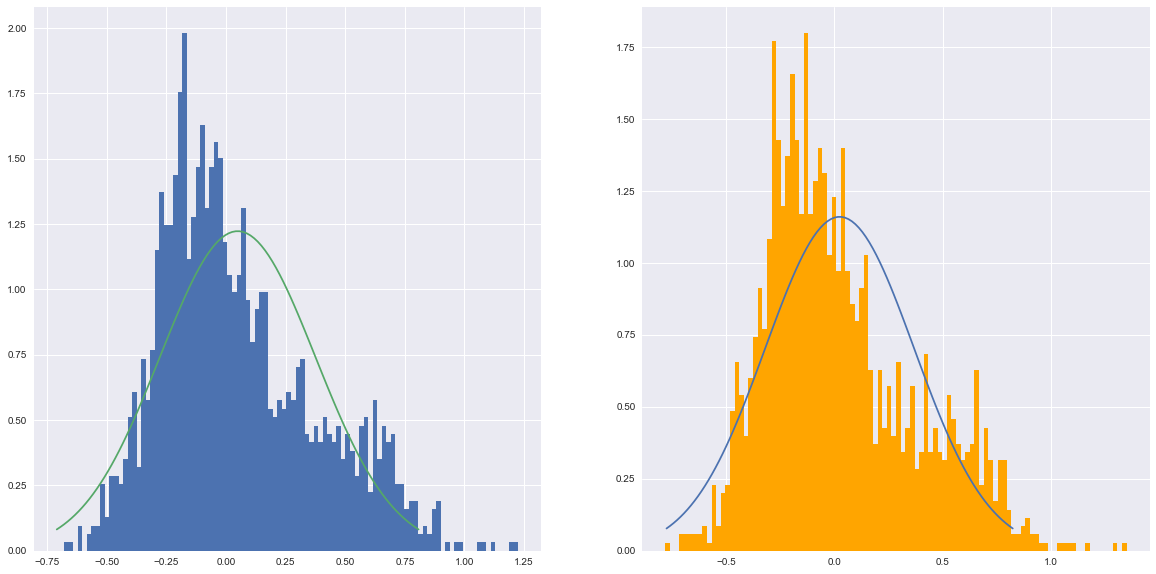

In [11]:
plt.figure(1, figsize=(20,10))

plt.subplot(1,2,1)
plt.hist(data['GCAG'], bins=100, density=True)
plt.plot(x_gcag,y_gcag)

plt.subplot(1,2,2)
plt.hist(data['GISTEMP'], bins=100, density=True, color='orange')
plt.plot(x_gistemp,y_gistemp)

plt.show()

---

Fitted exponnorm distribution with error=1.6795469686137436)


/home/user/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


,sumsquare_error
exponnorm,1.679547


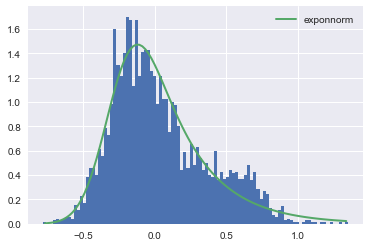

In [12]:
from fitter import Fitter
f = Fitter(data, distributions=['exponnorm'])
f.fit()
f.summary()

In [13]:
data['timestamp'] = pd.to_datetime(data.index.values).astype(np.int64)

In [14]:
# conversion of timestamp from nanoseconds to seconds 

data['timestamp'] = data['timestamp'] / 10**9

In [15]:
data.head()

Source,GCAG,GISTEMP,timestamp
Date,,,
1880-01-06,0.0009,-0.30,-2.839709e+09
1880-02-06,-0.1229,-0.21,-2.837030e+09
1880-03-06,-0.1357,-0.18,-2.834525e+09
1880-04-06,-0.0499,-0.27,-2.831846e+09
1880-05-06,-0.0738,-0.14,-2.829254e+09


In [16]:
np.array(data['timestamp'], dtype=pd.Series).reshape(-1, 1)

array([[-2839708800.0],
       [-2837030400.0],
       [-2834524800.0],
       ...,
       [1475712000.0],
       [1478390400.0],
       [1480982400.0]], dtype=object)

--- 
## Nearest Neighbors Regression

In [17]:
# Fit regression model

n_neighbors = 40
x = np.array(data['timestamp'], dtype=pd.Series).reshape(-1, 1) # timeline 
y = data['GCAG'].values # training data 
z = data['GISTEMP'].values # test data 

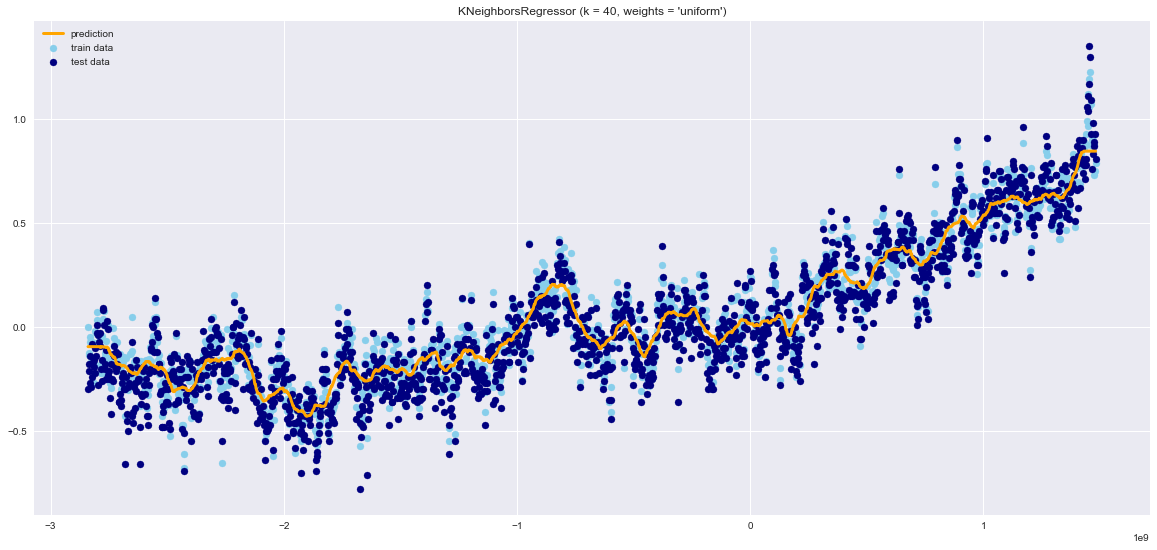

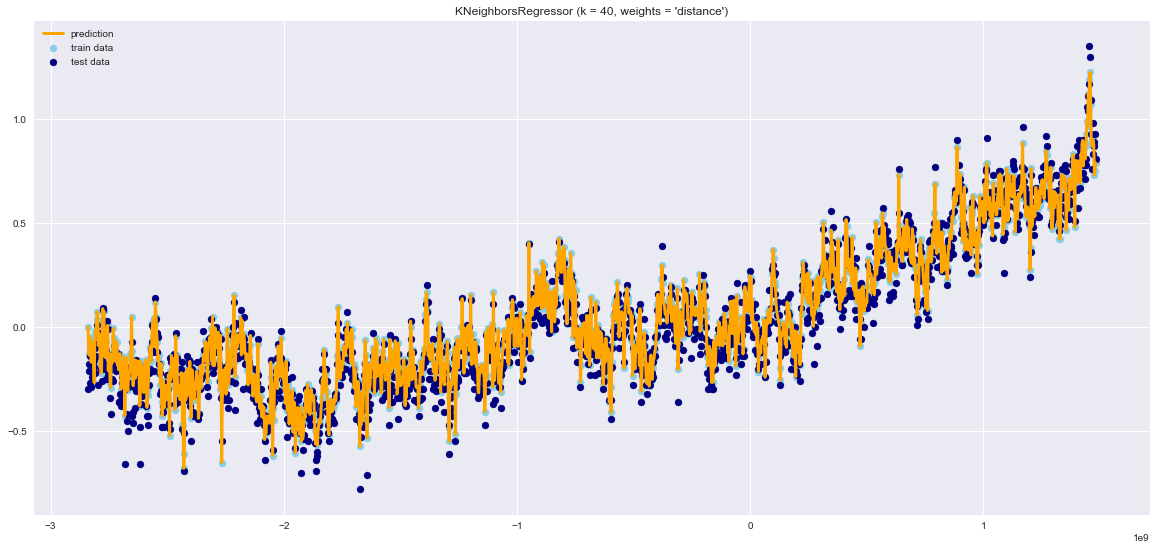

In [18]:
for i, weights in enumerate(['uniform', 'distance']):
    knr = KNeighborsRegressor(n_neighbors, weights=weights)
    y_prediction = knr.fit(x, y).predict(x)
    
    plt.figure(figsize=(20,20))
    plt.subplot(2,1,i+1)
    plt.scatter(x, y, c='skyblue', label='train data')
    plt.scatter(x, z, c='navy', label='test data')
    plt.plot(x, y_prediction, color='orange', linewidth=3, label='prediction')
    plt.axis('tight')
    plt.legend()
    plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors, weights))

plt.show()